Построить классификатор изображений: определение модели автомобиля по фото.  

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import csv
import sys
import os
import math

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback, LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB7
import efficientnet.keras as efn
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [1]:
# Обновление tensorflow
! pip install tensorflow==2.4.1
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации
! pip install git+https://github.com/mjkvaak/ImageDataAugmentor
#! pip freeze
! pip install efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-9pc5rjal
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-9pc5rjal
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=26a6e73d1f02555a82f34c958bd18dc4af227d6b17be4649be2c994c928b50af
  Stored in directory: /tmp/pip-ephem-wheel-cache-l605qmta/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 50 kB 687 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# В setup выносим основные настройки

EPOCHS = 5  # эпох на обучение
BATCH_SIZE = 48
LR = 1e-4
VAL_SPLIT = 0.15 # выделяем на тест

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE = 300 # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

RANDOM_SEED = 42
DATA_PATH = '../input/sfcarclassif/'
PATH = "../working/car/" # рабочая директория

## EDA / Анализ данных

In [5]:
train_df = pd.read_csv(DATA_PATH+'train.csv')
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [6]:
train_df = pd.read_csv(DATA_PATH+'train.csv')
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [8]:
# распределение классов
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение класснов равномерное

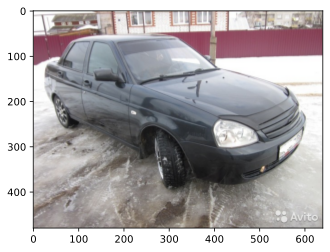

(640, 480)

In [9]:
# пример картинки
img = PIL.Image.open(DATA_PATH+'train/train/0/100379.jpg')
imgplot = plt.imshow(img)
plt.show()
img.size

## Подготовка данных
Аугментация данных

In [10]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range = 40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   #validation_split=VAL_SPLIT, # set validation split
                                   zoom_range=0.2, # увеличение изображения на случайное значение до 20%
                                   fill_mode='nearest',
                                   horizontal_flip=True)

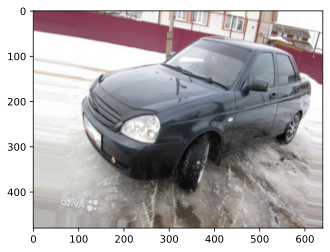

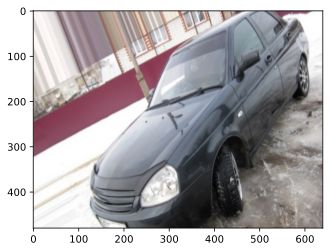

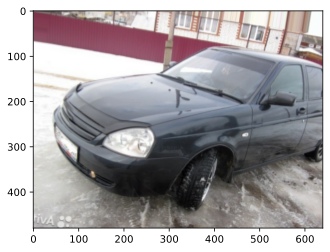

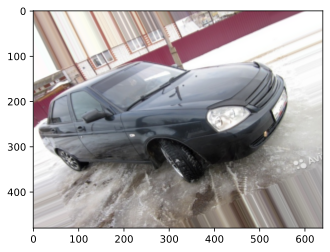

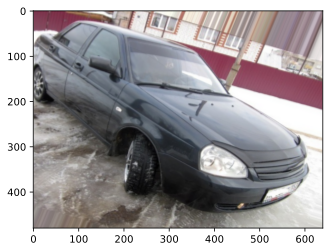

In [12]:
# проверяем работу генератора
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break
        
plt.show()

In [13]:
# создаем генератор данных для обучения
train_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/train', 
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    target_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    subset='training',
)

Found 15561 images belonging to 10 classes.


In [14]:
# создаем генератор данных для тестирования и валидации (для проверки уже не нужна аугментация)
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VAL_SPLIT, # set validation split
)

In [15]:
test_generator = test_datagen.flow_from_directory(
    DATA_PATH+'train/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 2329 images belonging to 10 classes.


# Модель

Для начала попробуем в качестве базовой модели использовать Xception

In [16]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [17]:
print(len(base_model.layers))

132


In [ ]:
# в качестве базы можно также взять архитектуру модели EfficientNetB5 (https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB5)
# base_model = efn.EfficientNetB5(weights='imagenet', 
#                                 include_top=False, 
#                                 input_shape = input_shape)
# base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape = input_shape)
# base_model = VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

In [18]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

на основе предобученной модели создаем новую составную сеть

In [20]:
from keras.models import Sequential
# заморозим веса базовой модели
base_model.trainable = False
model = Sequential()
# добавляем предобученную модель вместо слоя
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(CLASS_NUM, activation='softmax'))

# компилируем модель
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR),
              metrics=["accuracy"])

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [21]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_acc'] , verbose = 1  , mode = 'max')
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [early_stopping, checkpoint]

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 21,389,618
Trainable params: 527,626
Non-trainable params: 20,861,992
____________________________________

In [23]:
# обучаем модель с использованием генераторов
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    validation_data = test_generator, 
    validation_steps = len(test_generator),
    epochs = EPOCHS,
    callbacks = callbacks_list
)

Epoch 1/5
325/325 [==============================] - 526s 2s/step - loss: 2.0473 - accuracy: 0.3144 - val_loss: 1.3677 - val_accuracy: 0.5659

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
325/325 [==============================] - 440s 1s/step - loss: 1.3689 - accuracy: 0.5170 - val_loss: 1.0317 - val_accuracy: 0.6410

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
325/325 [==============================] - 441s 1s/step - loss: 1.2334 - accuracy: 0.5613 - val_loss: 0.9526 - val_accuracy: 0.6651

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
325/325 [==============================] - 442s 1s/step - loss: 1.1395 - accuracy: 0.5989 - val_loss: 0.8802 - val_accuracy: 0.6857

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
325/325 [==============================] - 441s 1s/step - loss: 1.0780 - accuracy: 0.6129 - val_loss: 0.8439 - val_accuracy: 0.6994

Epoch 00005: saving model to best_model.hdf5


In [25]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 20s 411ms/step - loss: 0.8439 - accuracy: 0.6994
Accuracy: 69.94%


На данном этапе результат всего 69.94%

In [26]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

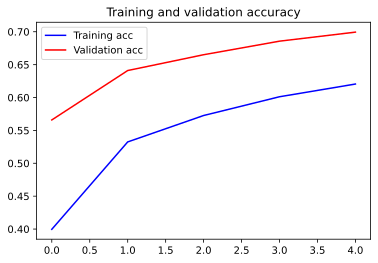

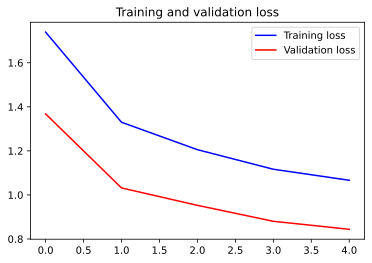

In [27]:
# визуализация
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss'] 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Попробуем теперь в качестве базовой модели взять предобученную модель VGG16

In [36]:
from tensorflow.keras.applications import VGG16

P.S. Результаат с VGG16 ухудшился

In [37]:
# в качестве базы можно также взять архитектуру модели EfficientNetB5 (https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB5)
# base_model = efn.EfficientNetB5(weights='imagenet', 
#                                 include_top=False, 
#                                 input_shape = input_shape)
# base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape = input_shape)
# base_model_nev_v2 = EfficientNetV2(weights='imagenet', include_top=False, input_shape = input_shape) 
# base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

58892288/58889256 [==============================] - 0s 0us/step


Так как результат с vgg хуже, вернуем Xception   
попробуем поработать теперь с архитектурой

In [44]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [45]:
# заморозим веса базовой модели
# base_model_vgg.trainable = False
base_model.trainable = False
model = Sequential()
# добавляем предобученную модель вместо слоя
# model.add(base_model_vgg)
model.add(base_model)
model.add(GlobalAveragePooling2D())
# усложним архитектуру модели
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())  # для ускорения обучения нейронной сети
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))
model.add(Dropout(0.25))
model.add(Dense(CLASS_NUM, activation='softmax'))


# комплируем модель
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR),
              metrics=["accuracy"])

In [46]:
# обучаем модель
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    validation_data = test_generator, 
    validation_steps = len(test_generator),
    epochs = EPOCHS,
    callbacks = callbacks_list
)

Epoch 1/5
325/325 [==============================] - 460s 1s/step - loss: 2.3309 - accuracy: 0.1609 - val_loss: 1.9263 - val_accuracy: 0.3903

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
325/325 [==============================] - 453s 1s/step - loss: 1.9279 - accuracy: 0.3065 - val_loss: 1.5700 - val_accuracy: 0.4246

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
325/325 [==============================] - 454s 1s/step - loss: 1.7143 - accuracy: 0.3758 - val_loss: 1.3716 - val_accuracy: 0.5024

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
325/325 [==============================] - 454s 1s/step - loss: 1.5852 - accuracy: 0.4195 - val_loss: 1.2253 - val_accuracy: 0.5865

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
325/325 [==============================] - 451s 1s/step - loss: 1.4579 - accuracy: 0.4678 - val_loss: 1.1471 - val_accuracy: 0.6046

Epoch 00005: saving model to best_model.hdf5


In [47]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 21s 431ms/step - loss: 1.1471 - accuracy: 0.6046
Accuracy: 60.46%


## Fine-tuning

Заморозка части слоев

In [48]:
# разморозим веса
base_model.trainable = True

# Заморозим половину слоев
for layer in base_model.layers[:len(base_model.layers) // 2]:
    layer.trainable =  False

In [49]:
# компилируем модель
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [50]:
# обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=test_generator, 
        validation_steps=test_generator.samples//test_generator.batch_size,
        epochs=EPOCHS,
        callbacks=callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
324/324 [==============================] - 499s 2s/step - loss: 1.2175 - accuracy: 0.5548 - val_loss: 0.3622 - val_accuracy: 0.8785

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
324/324 [==============================] - 483s 1s/step - loss: 0.5428 - accuracy: 0.8169 - val_loss: 0.2064 - val_accuracy: 0.9128

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
324/324 [==============================] - 476s 1s/step - loss: 0.3489 - accuracy: 0.8770 - val_loss: 0.1380 - val_accuracy: 0.9544

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
324/324 [==============================] - 493s 2s/step - loss: 0.2496 - accuracy: 0.9186 - val_loss: 0.1168 - val_accuracy: 0.9575

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
324/324 [==============================] - 473s 1s/step - loss: 0.2105 - accuracy: 0.9315 - val_loss: 0.1121 - val_accuracy: 0.9570

Epoch 00005: saving model to best_model.hdf5


In [51]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 21s 418ms/step - loss: 0.1110 - accuracy: 0.9575
Accuracy: 95.75%


In [52]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

## Fine-tuning (вся сеть)

In [53]:
# размораживаем все слои
base_model.trainable = True

In [54]:
# Compiling the model.
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [55]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=test_generator, 
        validation_steps=test_generator.samples//test_generator.batch_size,
        epochs=EPOCHS,
        callbacks=callbacks_list
)

Epoch 1/5
324/324 [==============================] - 575s 2s/step - loss: 0.2109 - accuracy: 0.9341 - val_loss: 0.0957 - val_accuracy: 0.9674

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
324/324 [==============================] - 575s 2s/step - loss: 0.1777 - accuracy: 0.9412 - val_loss: 0.0866 - val_accuracy: 0.9674

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
324/324 [==============================] - 588s 2s/step - loss: 0.1339 - accuracy: 0.9584 - val_loss: 0.0794 - val_accuracy: 0.9727

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
324/324 [==============================] - 580s 2s/step - loss: 0.1295 - accuracy: 0.9576 - val_loss: 0.0615 - val_accuracy: 0.9796

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
324/324 [==============================] - 575s 2s/step - loss: 0.1109 - accuracy: 0.9639 - val_loss: 0.0593 - val_accuracy: 0.9740

Epoch 00005: saving model to best_model.hdf5


In [56]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 21s 428ms/step - loss: 0.0587 - accuracy: 0.9742
Accuracy: 97.42%


In [57]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
## настройка lr
# def step_decay(epoch):
#     initial_lrate = 0.1
#     drop = 0.5
#     epochs_drop = 10.0
#     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#     return lrate

# learning schedule callback
# lrate = LearningRateScheduler(step_decay)

In [ ]:
# callbacks_list = [
#     tf.keras.callbacks.EarlyStopping(patience=2),
#     tf.keras.callbacks.ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max'),
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
# #     lrate,
# ]

In [ ]:
# # learn is an instance of Learner class or one of derived classes like ConvLearner
# model.lr_find()
# model.sched.plot_lr()

Попробуем добавить аугментацию тестовых данных (библиотека albumentations)

In [58]:
# Loading best weights.
model.load_weights('best_model.hdf5')

In [74]:
# AUGMENTATIONS = albumentations.Compose([
#     albumentations.HorizontalFlip(p=0.5),
#     albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
#     albumentations.OneOf([
#         albumentations.CenterCrop(height=224, width=200),
#         albumentations.CenterCrop(height=200, width=224),
#     ],p=0.5),
#     albumentations.OneOf([
#         albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
#         albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
#     ],p=0.5),
#     albumentations.GaussianBlur(p=0.05),
#     albumentations.LongestMaxSize(p=0.5),
#     albumentations.HueSaturationValue(p=0.5),
#     albumentations.RGBShift(p=0.5),
#     albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
# #     albumentations.MaskDropout(p=0.5),
#     albumentations.CLAHE(p=0.5),
#     albumentations.RandomBrightness(limit=0.2, p=0.5),
#     albumentations.Resize(IMG_SIZE, IMG_SIZE)
# ])

# test_datagen = ImageDataAugmentor( 
#     rescale=1./255,
#     augment=AUGMENTATIONS,
#     validation_split=VAL_SPLIT,
# )

# Предсказание на тестовых данных

In [69]:
test_datagen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_datagen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=DATA_PATH+'test/test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [70]:
test_sub_generator.samples

6675

In [71]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, 
                                      steps=len(test_sub_generator), 
                                      verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

140/140 [==============================] - 66s 477ms/step


In [72]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission2.csv', index=False)
print('Save submit')

Save submit


In [73]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9
